In [1]:
# env: esm1
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# model.eval().to(device)

Using device: cuda


In [2]:
# Check for duplicate rows in tb_df
duplicate_rows = tb_df[tb_df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])
if not duplicate_rows.empty:
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

# Alternatively, check for duplicate sequences specifically
duplicate_sequences = tb_df[tb_df.duplicated(subset="Sequences")]
print("Number of duplicate sequences:", duplicate_sequences.shape[0])
if not duplicate_sequences.empty:
    print(duplicate_sequences)
else:
    print("No duplicate sequences found.")

NameError: name 'tb_df' is not defined

## spatial plot

In [5]:

# Load ESM-1b model and alphabet
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval().cuda()  # Use GPU if available

# Example: sequences to embed
# Replace this with your DataFrame or sequence list
# df = pd.read_csv("your_sequences.csv")
# sequences = df["Sequences"].tolist()
sequences = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models/generated_peptides.fasta", "fasta")]

# Prepare data: ESM expects list of (name, sequence) tuples
data = [(f"seq{i}", seq) for i, seq in enumerate(sequences)]

# Batch encode and extract embeddings
all_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(data), 8)):  # small batches if memory constrained
        batch_data = data[i:i+8]
        labels, strs, tokens = batch_converter(batch_data)
        tokens = tokens.cuda()

        # Extract representations from the final layer
        results = model(tokens, repr_layers=[33], return_contacts=False)
        token_representations = results["representations"][33]

        for j, (_, seq) in enumerate(batch_data):
            # Extract per-sequence embedding: mean of all token embeddings (excluding special tokens)
            emb = token_representations[j, 1:len(seq)+1].mean(0)  # shape: (1280,)
            all_embeddings.append(emb.cpu().numpy())

# Convert to DataFrame
embedding_df = pd.DataFrame(all_embeddings)
embedding_df["sequence"] = sequences

# Save if needed
# embedding_df.to_csv("esm1b_embeddings.csv", index=False)

print("✅ ESM-1b embeddings generated and saved.")


100%|██████████| 13/13 [00:01<00:00, 11.53it/s]

✅ ESM-1b embeddings generated and saved.


100%|██████████| 38/38 [03:27<00:00,  5.45s/it]


Explained variance by first 50 components: 0.92


/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


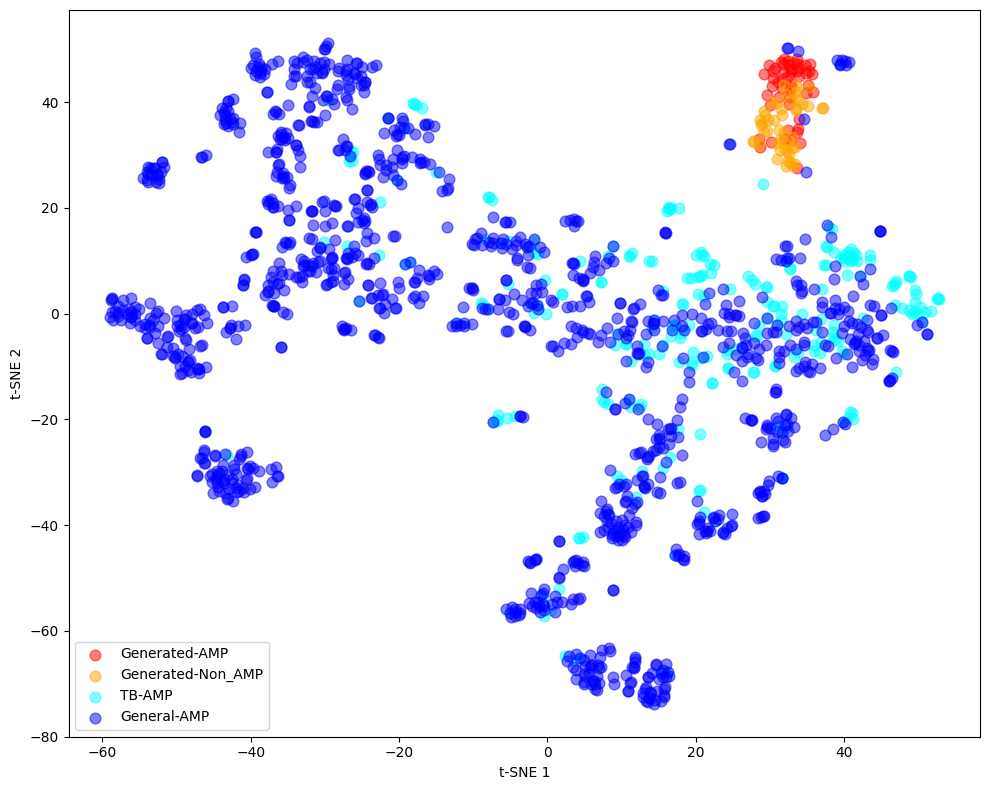

In [ ]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm_embeddings(sequence_list, label_prefix, batch_size=32):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]

            for j, (_, seq) in enumerate(batch_data):
                emb = token_representations[j, 1:len(seq)+1].mean(0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences = [str(record.seq) for record in SeqIO.parse(
    "/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/generated_peptides-notrans.fasta", "fasta")]
gen_embeddings_pos, gen_labels_pos = extract_esm_embeddings(generated_sequences, "Generated-AMP")

generated_sequences = [str(record.seq) for record in SeqIO.parse(
    "/mnt/storageG1/lwang/Projects/TB-AMP-design/models/1745346340796_AMPCandidates0.7-neg.fa", "fasta")]
gen_embeddings_neg, gen_labels_neg = extract_esm_embeddings(generated_sequences, "Generated-Non_AMP")


# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv")
ref_df = ref_df.drop_duplicates(subset='Sequences')

df_filtered = ref_df

def split_sequence(seq, chunk_size=20):
    return [seq[i:i+chunk_size] for i in range(0, len(seq), chunk_size)]

new_rows = []
for _, row in df_filtered.iterrows():
    seq = row['Sequences']
    amp_label = row['AMP']
    if len(seq) > 40:
        for chunk in split_sequence(seq, 20):
            new_rows.append({'Sequences': chunk, 'AMP': amp_label})
    else:
        new_rows.append({'Sequences': seq, 'AMP': amp_label})

df_filtered = pd.DataFrame(new_rows)
ref_df = df_filtered
ref_df = ref_df[
    (ref_df['Sequences'].str.len() >= 10) &
    (ref_df['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~ref_df['Sequences'].str.contains('X'))
]
ref_df = ref_df.loc[ref_df['AMP'] == 1, :]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm_embeddings(reference_sequences, "TB-AMP")

################

adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df.columns = ['Peptide ID', 'Sequences']
adam_df = adam_df.drop_duplicates(subset='Sequences')
adam_df = adam_df[~adam_df['Sequences'].isin(ref_df['Sequences'])]
filtered_adam_df = adam_df[
    (adam_df['Sequences'].str.len() >= 10) &
    (adam_df['Sequences'].str.len() <= 40)
].reset_index(drop=True)

adam_df = filtered_adam_df[:1200]
reference_sequences = adam_df["Sequences"].tolist()
general_embeddings, general_labels = extract_esm_embeddings(reference_sequences, "General-AMP")


# Combine and reduce
all_embeddings = gen_embeddings_pos + gen_embeddings_neg +ref_embeddings + general_embeddings
all_labels = gen_labels_pos + gen_labels_neg +ref_labels + general_labels

pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)

# Calculate how much variance is explained by the first 50 components
explained_variance_50d = np.sum(pca_model.explained_variance_ratio_)
print(f"Explained variance by first 50 components: {explained_variance_50d:.2f}")
# Apply t-SNE on the PCA result
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

# Plot using matplotlib
vis_df = pd.DataFrame(tsne, columns=["x", "y"])
vis_df["Source"] = all_labels

colors = {
    "Generated-AMP": "red",
    "Generated-Non_AMP": "orange",
    "TB-AMP": "cyan",
    "General-AMP": "blue"
}
plt.figure(figsize=(10, 8))
for label in vis_df["Source"].unique():
    subset = vis_df[vis_df["Source"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, alpha=0.5, s=60, c=colors[label])

# plt.title("t-SNE of ESM-1b Embeddings: Generated vs Reference AMPs")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()


### working version

100%|██████████| 38/38 [03:49<00:00,  6.05s/it]


Explained variance by first 50 components: 0.95


/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


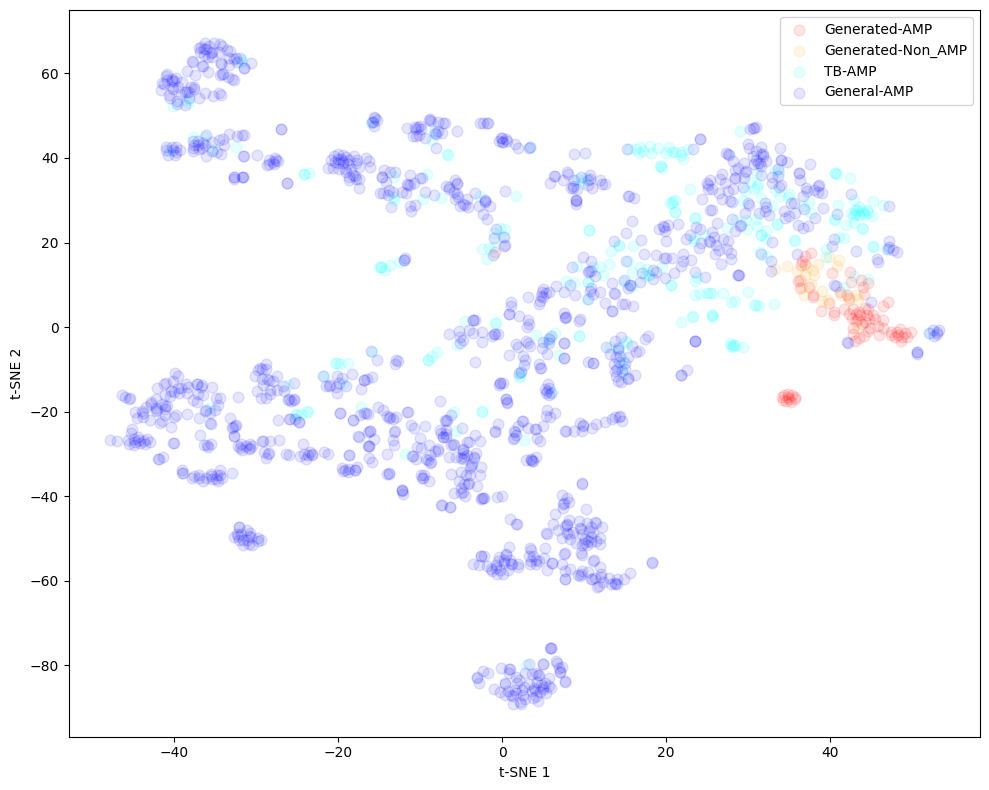

In [3]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm_embeddings(sequence_list, label_prefix, batch_size=32):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]

            for j, (_, seq) in enumerate(batch_data):
                emb = token_representations[j, 1:len(seq)+1].mean(0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences = [str(record.seq) for record in SeqIO.parse(
    "/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-pos.fa", "fasta")]
gen_embeddings_pos, gen_labels_pos = extract_esm_embeddings(generated_sequences, "Generated-AMP")

generated_sequences = [str(record.seq) for record in SeqIO.parse(
    "/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-neg.fa", "fasta")]
gen_embeddings_neg, gen_labels_neg = extract_esm_embeddings(generated_sequences, "Generated-Non_AMP")


# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv")
ref_df = ref_df.drop_duplicates(subset='Sequences')

df_filtered = ref_df

def split_sequence(seq, chunk_size=20):
    return [seq[i:i+chunk_size] for i in range(0, len(seq), chunk_size)]

new_rows = []
for _, row in df_filtered.iterrows():
    seq = row['Sequences']
    amp_label = row['AMP']
    if len(seq) > 40:
        for chunk in split_sequence(seq, 20):
            new_rows.append({'Sequences': chunk, 'AMP': amp_label})
    else:
        new_rows.append({'Sequences': seq, 'AMP': amp_label})

df_filtered = pd.DataFrame(new_rows)
ref_df = df_filtered
ref_df = ref_df[
    (ref_df['Sequences'].str.len() >= 10) &
    (ref_df['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~ref_df['Sequences'].str.contains('X'))
]
ref_df = ref_df.loc[ref_df['AMP'] == 1, :]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm_embeddings(reference_sequences, "TB-AMP")

################

adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df.columns = ['Peptide ID', 'Sequences']
adam_df = adam_df.drop_duplicates(subset='Sequences')
adam_df = adam_df[~adam_df['Sequences'].isin(ref_df['Sequences'])]
filtered_adam_df = adam_df[
    (adam_df['Sequences'].str.len() >= 10) &
    (adam_df['Sequences'].str.len() <= 40)
].reset_index(drop=True)

adam_df = filtered_adam_df[:1200]
reference_sequences = adam_df["Sequences"].tolist()
general_embeddings, general_labels = extract_esm_embeddings(reference_sequences, "General-AMP")


# Combine and reduce
all_embeddings = gen_embeddings_pos + gen_embeddings_neg +ref_embeddings + general_embeddings
all_labels = gen_labels_pos + gen_labels_neg +ref_labels + general_labels

pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)

# Calculate how much variance is explained by the first 50 components
explained_variance_50d = np.sum(pca_model.explained_variance_ratio_)
print(f"Explained variance by first 50 components: {explained_variance_50d:.2f}")
# Apply t-SNE on the PCA result
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

# Plot using matplotlib
vis_df = pd.DataFrame(tsne, columns=["x", "y"])
vis_df["Source"] = all_labels

colors = {
    "Generated-AMP": "red",
    "Generated-Non_AMP": "orange",
    "TB-AMP": "cyan",
    "General-AMP": "blue"
}
plt.figure(figsize=(10, 8))
for label in vis_df["Source"].unique():
    subset = vis_df[vis_df["Source"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, alpha=0.1, s=60, c=colors[label])

# plt.title("t-SNE of ESM-1b Embeddings: Generated vs Reference AMPs")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
aps_sequences = [str(record.seq) for record in SeqIO.parse("./database_check/aps.fasta", "fasta")]
aps_sequences = [str(record.seq) for record in SeqIO.parse("./database_check/aps.fasta", "fasta")]
print(pd.Series(aps_sequences).isna().sum())

0


100%|██████████| 731/731 [1:16:43<00:00,  6.30s/it]


Explained variance by first 50 components: 0.94


/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


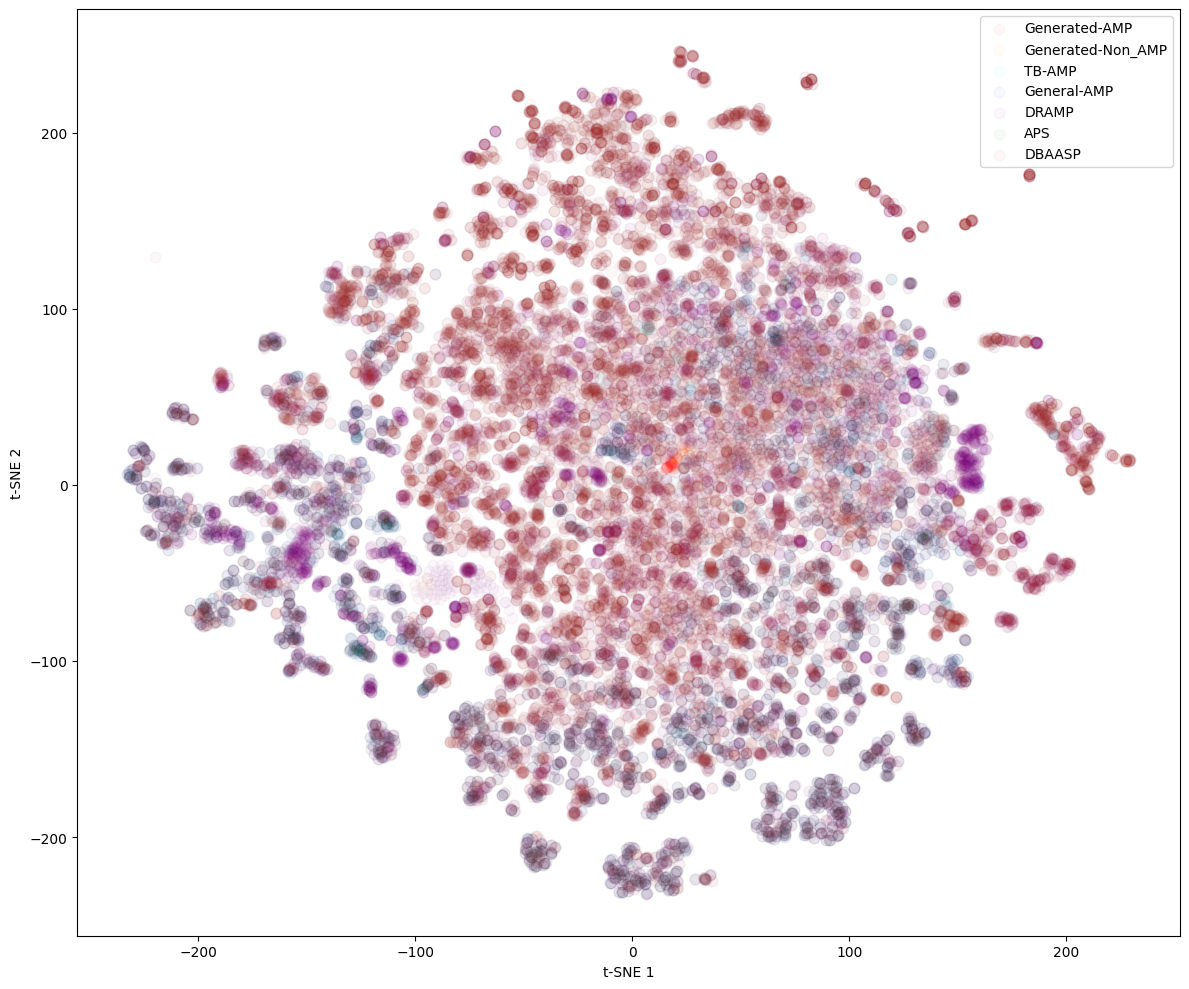

In [5]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm_embeddings(sequence_list, label_prefix, batch_size=32):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]

            for j, (_, seq) in enumerate(batch_data):
                emb = token_representations[j, 1:len(seq)+1].mean(0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences_pos = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-pos.fa", "fasta")]
generated_sequences_neg = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-neg.fa", "fasta")]

# Extract embeddings
gen_embeddings_pos, gen_labels_pos = extract_esm_embeddings(generated_sequences_pos, "Generated-AMP")
gen_embeddings_neg, gen_labels_neg = extract_esm_embeddings(generated_sequences_neg, "Generated-Non_AMP")

# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv").drop_duplicates(subset='Sequences')
ref_df = ref_df[(ref_df['AMP'] == 1) & (ref_df['Sequences'].str.len().between(10, 40))]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm_embeddings(reference_sequences, "TB-AMP")

# General AMP sequences from ADAM
adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df.columns = ['Peptide ID', 'Sequences']
adam_df = adam_df.drop_duplicates(subset='Sequences')
adam_sequences = adam_df['Sequences'].str[:1200].tolist()
general_embeddings, general_labels = extract_esm_embeddings(adam_sequences, "General-AMP")

# DRAMP sequences
dramps_df = pd.read_csv("./database_check/dramps_general_amps.txt", sep='\t')
dramps_sequences = dramps_df['Sequence'].dropna().tolist()
dramps_embeddings, dramps_labels = extract_esm_embeddings(dramps_sequences, "DRAMP")

# APS sequences
aps_sequences = [str(record.seq) for record in SeqIO.parse("./database_check/aps.fasta", "fasta")]
aps_embeddings, aps_labels = extract_esm_embeddings(aps_sequences, "APS")

# DBAASP sequences
dbbasp_df = pd.read_csv("./database_check/DBAASP_peptides.csv")
dbbasp_sequences = dbbasp_df['SEQUENCE'].dropna().tolist()
dbbasp_embeddings, dbbasp_labels = extract_esm_embeddings(dbbasp_sequences, "DBAASP")

# Combine embeddings
all_embeddings = (gen_embeddings_pos + gen_embeddings_neg + ref_embeddings + general_embeddings +
                  dramps_embeddings + aps_embeddings + dbbasp_embeddings)

all_labels = (gen_labels_pos + gen_labels_neg + ref_labels + general_labels +
              dramps_labels + aps_labels + dbbasp_labels)

all_embeddings = np.array(all_embeddings)
# Find indices without NaNs
valid_indices = ~np.isnan(all_embeddings).any(axis=1)
# Filter embeddings and labels to remove NaN-containing entries
all_embeddings = all_embeddings[valid_indices]
all_labels = np.array(all_labels)[valid_indices]

# PCA reduction
pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)

explained_variance_50d = np.sum(pca_model.explained_variance_ratio_)
print(f"Explained variance by first 50 components: {explained_variance_50d:.2f}")

# t-SNE visualization
tsne_result = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

vis_df = pd.DataFrame(tsne_result, columns=["x", "y"])
vis_df["Source"] = all_labels

# Plot results
colors = {
    "Generated-AMP": "red", "Generated-Non_AMP": "orange", "TB-AMP": "cyan", "General-AMP": "blue",
    "DRAMP": "purple", "APS": "green", "DBAASP": "brown"
}

plt.figure(figsize=(12, 10))
for label in vis_df["Source"].unique():
    subset = vis_df[vis_df["Source"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, alpha=0.03, s=60, c=colors[label])

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm_embeddings(sequence_list, label_prefix, batch_size=32):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]

            for j, (_, seq) in enumerate(batch_data):
                emb = token_representations[j, 1:len(seq)+1].mean(0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences_pos = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-pos.fa", "fasta")]
generated_sequences_neg = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models1/1745429455143_AMPCandidates-neg.fa", "fasta")]

# Extract embeddings
gen_embeddings_pos, gen_labels_pos = extract_esm_embeddings(generated_sequences_pos, "Generated-AMP")
gen_embeddings_neg, gen_labels_neg = extract_esm_embeddings(generated_sequences_neg, "Generated-Non_AMP")

# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv").drop_duplicates(subset='Sequences')
ref_df = ref_df[(ref_df['AMP'] == 1) & (ref_df['Sequences'].str.len().between(10, 40))]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm_embeddings(reference_sequences, "TB-AMP")

# General AMP sequences from ADAM
adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df.columns = ['Peptide ID', 'Sequences']
adam_df = adam_df.drop_duplicates(subset='Sequences')
adam_sequences = adam_df['Sequences'].str[:1200].tolist()
general_embeddings, general_labels = extract_esm_embeddings(adam_sequences, "General-AMP")

# DRAMP sequences
dramps_df = pd.read_csv("./database_check/dramps_general_amps.txt", sep='\t')
dramps_sequences = dramps_df['Sequence'].dropna().tolist()
dramps_embeddings, dramps_labels = extract_esm_embeddings(dramps_sequences, "DRAMP")

# APS sequences
aps_sequences = [str(record.seq) for record in SeqIO.parse("./database_check/aps.fasta", "fasta")]
aps_embeddings, aps_labels = extract_esm_embeddings(aps_sequences, "APS")

# DBAASP sequences
dbbasp_df = pd.read_csv("./database_check/DBAASP_peptides.csv")
dbbasp_sequences = dbbasp_df['SEQUENCE'].dropna().tolist()
dbbasp_embeddings, dbbasp_labels = extract_esm_embeddings(dbbasp_sequences, "DBAASP")

# Combine embeddings
all_embeddings = (gen_embeddings_pos + gen_embeddings_neg + ref_embeddings + general_embeddings +
                  dramps_embeddings + aps_embeddings + dbbasp_embeddings)

all_labels = (gen_labels_pos + gen_labels_neg + ref_labels + general_labels +
              dramps_labels + aps_labels + dbbasp_labels)

all_embeddings = np.array(all_embeddings)
# Find indices without NaNs
valid_indices = ~np.isnan(all_embeddings).any(axis=1)
# Filter embeddings and labels to remove NaN-containing entries
all_embeddings = all_embeddings[valid_indices]
all_labels = np.array(all_labels)[valid_indices]

# PCA reduction
pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)

explained_variance_50d = np.sum(pca_model.explained_variance_ratio_)
print(f"Explained variance by first 50 components: {explained_variance_50d:.2f}")

# t-SNE visualization
tsne_result = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

vis_df = pd.DataFrame(tsne_result, columns=["x", "y"])
vis_df["Source"] = all_labels

# Plot results
colors = {
    "Generated-AMP": "red", "Generated-Non_AMP": "orange", "TB-AMP": "cyan", "General-AMP": "blue",
    "DRAMP": "purple", "APS": "green", "DBAASP": "brown"
}

# Plot each set separately with same axis range
plt.figure(figsize=(18, 12))
unique_labels = vis_df["Source"].unique()

for i, label in enumerate(unique_labels, 1):
    subset = vis_df[vis_df["Source"] == label]
    plt.subplot(3, 3, i)  # Adjust rows/columns as needed for layout
    plt.scatter(subset["x"], subset["y"], alpha=0.6, s=30, c=colors[label], label=label)
    plt.title(label)
    plt.xlim(-250, 250)
    plt.ylim(-250, 250)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)

plt.tight_layout()
plt.show()


## presence of AMP

In [6]:
from Bio import SeqIO

def read_fasta_sequences(fasta_path):
    """
    Reads sequences from a FASTA file and returns them as a list of strings.

    Args:
        fasta_path (str): Path to the FASTA file.

    Returns:
        List[str]: A list of amino acid or nucleotide sequences as strings.
    """
    sequences = [str(record.seq) for record in SeqIO.parse(fasta_path, "fasta")]
    return sequences
generated = read_fasta_sequences("1745419634972_AMPCandidates-pos-nontox.fa") # transfer learning outputs
generated = read_fasta_sequences("1745429455143_AMPCandidates-pos-nontox.fa") # no transfer learning outputs
print(len(generated))

74


DRAMP

In [7]:
dramps = pd.read_csv("./database_check/dramps_general_amps.txt", sep = '\t')
dramps['Sequence']

0                           SLGPAIKATRQVCPKATRFVTVSCKKSDCQ
1                                 VTSWSLCTPGCTSPGGGSNCSFCC
2                                 GNGVLKTISHECNMNTWQFLFTCC
3                                    SSSGWLCTLTIECGTIICACR
4        MSWLNFLKYIAKYGKKAVSAAWKYKGKVLEWLNVGPTLEWVWQKLK...
                               ...                        
11607                                          LLLLLLLLLLL
11608                              LLLLLLLLLLLLLLLLLLLLLLL
11609                LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
11610                LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
11611                                   GAGIVVASIDTGVRVSHE
Name: Sequence, Length: 11612, dtype: object

In [8]:
# Create a set of sequences from dramps for faster lookup
dramps_set = set(dramps['Sequence'])

# Filter out sequences in generated that are present in dramps_set
generated = [seq for seq in generated if seq not in dramps_set]

print(f"Remaining sequences in 'generated': {len(generated)}")

Remaining sequences in 'generated': 74


APS

In [9]:
aps = read_fasta_sequences("./database_check/aps.fasta")


In [10]:
aps_set = set(aps)

generated = [seq for seq in generated if seq not in aps_set]

print(f"Remaining sequences in 'generated': {len(generated)}")

Remaining sequences in 'generated': 74


DBBASP

In [11]:
dbbasp = pd.read_csv("./database_check/DBAASP_peptides.csv")
dbbasp['SEQUENCE']

0        NLVSGLIEARKYLEQLHRKLKNCKV    ENREVPPGFTALIKTLR...
1                    WLNALLHHGLNCAKGVLA    ALLHHGLNCAKGVLA
2                   KWLNALLHHGLNCAKGVLA    ALLHHGLNCAKGVLA
3        SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG    IA...
4        XTCASRCPRPCNAGLCCSIYGYCGSGNAYCGAGNCRCQCRG    X...
                               ...                        
23358                                                  Rxr
23359                                                  RxR
23360                                                  rXr
23361                                                  RXr
23362                                                  rxR
Name: SEQUENCE, Length: 23363, dtype: object

In [12]:
aps_set = set(dbbasp['SEQUENCE'])

generated = [seq for seq in generated if seq not in aps_set]

print(f"Remaining sequences in 'generated': {len(generated)}")

Remaining sequences in 'generated': 74


Uniprot

In [13]:
import requests

def check_uniprot(peptide):
    url = f"https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": f"sequence:{peptide}",
        "format": "json",
        "fields": "accession,id,sequence"
    }
    response = requests.get(url, params=params)
    results = response.json()
    return results.get("results", [])

# Example usage
peptides = generated
for pep in peptides:
    hits = check_uniprot(pep)
    print(f"{pep}: {'✅ Found' if hits else '❌ Not found'}")


KAAYYPHGKKGKGPHKHKKG: ❌ Not found
IHWTKYGGGHKHKKHKGKGYKGDKKKKGKGPKKGKKKKP: ❌ Not found
IAKPKPKKKEGGKHKPHKK: ❌ Not found
FAAAYPKPMGPK: ❌ Not found
EQAAGKPPAKKHGKYKKKKYYHKHHG: ❌ Not found
VAADYGGKYHKKHKKKKKGK: ❌ Not found
DAAKKAKGKGKKYG: ❌ Not found
QAKVVPKGGPKDGK: ❌ Not found
CAGLKGKHHK: ❌ Not found
AMIKAHHHYKPKKKKKGKHG: ❌ Not found
DAWYYHAYKYYPHKPKGKYK: ❌ Not found
HAHYDKRKKKKHKKPPKKKK: ❌ Not found
TAAIKKKYKHKHKGGYKKKG: ❌ Not found
YAGMKHYKKKKH: ❌ Not found
AGAAAAPKKGKKGKK: ❌ Not found
VAAGKKPKGGKGKYKKKKKY: ❌ Not found
VARPPHGKPYKKKKYPKKKG: ❌ Not found
QAPEVHATGHYYKKKHKKKKKGKGKKPKGGKKGG: ❌ Not found
RAAAAGKKKYKHPHYDYGPK: ❌ Not found
WAGYKKKKKKPGHYPKKHGKKKGYYKKIKKGPKYKKKYPG: ❌ Not found
AAAASPYYKKYPHKGYKHK: ❌ Not found
GAAKKPKPKKPKGGKKKHGD: ❌ Not found
QAAGWHKMKKPYGTK: ❌ Not found
MAYHGKGGGGGGK: ❌ Not found
HAAPPGGKKKKKKGHKPKKGKKHHKGKHKGPKKKK: ❌ Not found
EAAADGGGHGPGKKYGKYPKHGKSKKHKGKKKHGKHKGK: ❌ Not found
DAAAAYHPHKKKKKKVKYGK: ❌ Not found
PAAPKPGPGGGKKKKPKKKKKHKKHPKKPKGYKKGK: ❌ Not fo

### scanner outputs

In [4]:
scanner = pd.read_csv("./1745419634972_results/1745419634972_Prediction_Summary.csv")
scanner = pd.read_csv("./1745429455143_results/1745429455143_Prediction_Summary.csv")


In [5]:
scanner.loc[scanner['Prediction_Class'] == 'AMP', :]
scanner.sort_values(by="Prediction_Probability", ascending=False)

,SeqID,Prediction_Class,Prediction_Probability,Sequence
3,peptide3,AMP,1.0000,IHWTKYGGGHKHKKHKGKGYKGDKKKKGKGPKKGKKKKP
33,peptide33,AMP,1.0000,HAAPPGGKKKKKKGHKPKKGKKHHKGKHKGPKKKK
25,peptide25,AMP,1.0000,WAGYKKKKKKPGHYPKKHGKKKGYYKKIKKGPKYKKKYPG
37,peptide37,AMP,1.0000,PAAPKPGPGGGKKKKPKKKKKHKKHPKKPKGYKKGK
74,peptide74,AMP,1.0000,VAYKSKKKKGGHKGKYGKKPGKKYKKKPKGVKKHKKKG
...,...,...,...,...
1,peptide1,Non-AMP,0.0755,AAADKGHKKKGKKG
65,peptide65,Non-AMP,0.0684,NAALRPDKGHYGKKKKDKKG
50,peptide50,Non-AMP,0.0670,LATAKHKKPGDGP
94,peptide94,Non-AMP,0.0172,SHIAEFKKHDGYHKK
